In [1]:
# Import MNIST dataset
# Generate empirical graph with 2 clusters
# For n in [2,4,10,20,40,100,200]
# Divide the data
# Modify the data in the second cluster
# Initialize commonly the models
# Run our algorithm
# First centralized, then noncentralized (the same thing for us?)
# Compare the result with global single converer (with wall time the same)

In [2]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision
import matplotlib.pyplot as plt
import numpy as np
from itertools import cycle
import random
%config InlineBackend.figure_format = 'retina'
DEVICE = "cuda" # or "cpu"
from tqdm.notebook import tqdm

# Load and normalize the MNIST data

In [3]:
#Download the datasets
dataset_train = torchvision.datasets.MNIST('../data', train=True, download=True,transform=torchvision.transforms.ToTensor())
dataset_test = torchvision.datasets.MNIST('../data', train=False, download=True,transform=torchvision.transforms.ToTensor())
# For normalization, get mean and std of the training dataset
train_loader = torch.utils.data.DataLoader(dataset_train, batch_size=len(dataset_train))
data = next(iter(train_loader))[0]
mean, std = data.mean().item(), data.std().item()
print("Mean pixel is",mean," and std is",std)

# Now we can load the dataset with normalizing transformation
transform = torchvision.transforms.Compose([
    torchvision.transforms.ToTensor(),
    torchvision.transforms.Normalize((mean,),(std,))
])
dataset_train.transform = transform
dataset_test.transform = transform

Mean pixel is 0.13066047430038452  and std is 0.30810782313346863


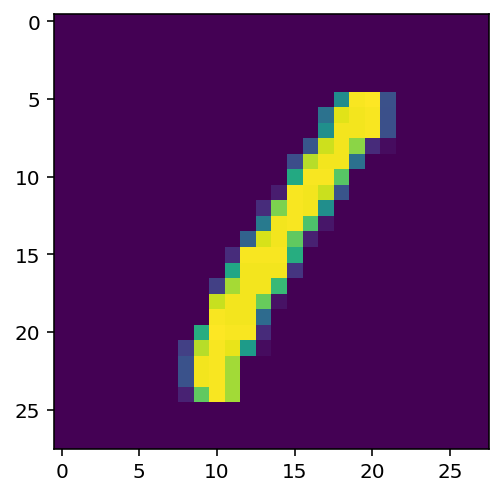

In [4]:
def showimg(tensor):
    plt.imshow(tensor.reshape(28,28))
showimg(dataset_train[3][0]); # plt.imshow does a min-max normalization, so it always looks the same

# Generate the empirical graph with 2 clusters using the stochastic graph model

In [5]:
from graspologic.simulations import sbm

# Return the adjacency matrix (as numpy.ndarray), where elements are the link strengths
def getAfromSBM(n1=5, n2=5, p_in=0.5, p_out=0.1, mu_in=8, mu_out=2):
    n = [n1,n2]
    p = [[p_in, p_out], [p_out, p_in]]
    wt = [[np.random.normal,np.random.normal], [np.random.normal, np.random.normal]]
    wtargs = [[dict(loc=mu_in, scale=0), dict(loc=mu_out, scale=0)],
              [dict(loc=mu_out,scale=0), dict(loc=mu_in,  scale=0)]]
    A = sbm(n=n, p=p, wt=wt, wtargs=wtargs)
    return A

# For example
print(getAfromSBM(3,3,0.5,0.3,3,1))
# Note: A is always symmetric, has no self-loops

[[0. 3. 0. 0. 0. 0.]
 [3. 0. 3. 0. 0. 1.]
 [0. 3. 0. 0. 1. 1.]
 [0. 0. 0. 0. 3. 0.]
 [0. 0. 1. 3. 0. 3.]
 [0. 1. 1. 0. 3. 0.]]


# Define the model and divide + transform the MNIST data

In [6]:
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(1, 32, 3, 1)
        self.conv2 = nn.Conv2d(32, 64, 3, 1)
        self.dropout1 = nn.Dropout(0.25)
        self.dropout2 = nn.Dropout(0.5)
        self.fc1 = nn.Linear(9216, 128)
        self.fc2 = nn.Linear(128, 10)

    def forward(self, x):
        x = self.conv1(x)
        x = F.relu(x)
        x = self.conv2(x)
        x = F.relu(x)
        x = F.max_pool2d(x, 2)
        x = self.dropout1(x)
        x = torch.flatten(x, 1)
        x = self.fc1(x)
        x = F.relu(x)
        x = self.dropout2(x)
        x = self.fc2(x)
        output = F.log_softmax(x, dim=1)
        return output

In [7]:
# Custom class to apply the transformation only to the other half
class MapDataset(torch.utils.data.Dataset):
    """
    Given a dataset, creates a dataset which applies a mapping function
    to its items (lazily, only when an item is called).
    
    Note that the data is not cloned/copied from the initial dataset"""
    def __init__(self, dataset, map_fn):
        self.dataset = dataset
        self.map = map_fn
    
    def __getitem__(self, index):
        # Apply the given function (self.map) only to the feature, not the label
        return (self.map(self.dataset[index][0]), self.dataset[index][1])
    
    def __len__(self):
        return len(self.dataset)
    
def sizes(num,div):
    return [num // div + (1 if x < num % div else 0) for x in range(div)]

def rotation_transform(img):
    return torch.rot90(img,1,[-1,-2])

def initialize_learners(n_learners=10,n_training_data=60000):
    #n_learners = 10 # learners in the first cluster are 0,1,2,3,4; in the second cluster 5,6,7,8,9
    n1 = n_learners // 2
    n2 = n_learners - n1
    n1_list = range(n1)
    n2_list = range(n1,n2)
    # divide the data evenly to n_learners, apply rotation_transform to the second half of datasets
    dataset_sizes = sizes(n_training_data, n_learners) + [60000 - n_training_data]
    datasets = torch.utils.data.random_split(dataset_train,dataset_sizes)[:-1] # drop the last one, holding the unused data
    datasets = [dataset if n in n1_list else MapDataset(dataset, rotation_transform) for (n,dataset) in enumerate(datasets)]
    dataloaders = [torch.utils.data.DataLoader(datasets[i], batch_size = 256) for i in range(n_learners)]
    testloader = torch.utils.data.DataLoader(dataset_test, batch_size = 256)

    # Initialize the models
    models = [Net().to(DEVICE) for i in range(n_learners)]
    # Copy the initialization from model 0 to all others
    for i in range(1,n_learners):
        models[i].load_state_dict(models[0].state_dict())
    return dataloaders, testloader, models

def L2(local, neighbor):
    return torch.norm(local - neighbor)

def L2_squared(local, neighbor):
    #return torch.norm(local - neighbor).pow(2)
    return (local - neighbor).pow(2).sum()

def pi_1(tensor):
    mask = torch.cat([torch.ones(18816,device=DEVICE),torch.zeros(1181066,device=DEVICE)])
    return tensor * mask

def pi_2(tensor):
    mask = torch.cat([torch.zeros(18816,device=DEVICE),torch.ones(1181066,device=DEVICE)])
    return tensor * mask

def L2_early(local,neighbor):
    return torch.norm(pi_1(local)-pi_1(neighbor))

def L2_early_squared(local,neighbor):
    return torch.norm(pi_1(local)-pi_1(neighbor)).pow(2)

# Define the local learning step and testing procedure

In [8]:
# Takes a single optimizer step. Note that the optimizer state is updated.
def train_single_step(model, dataiter, optimizer, neighbor_thetas, neighbor_weights, lambd=0, g=L2_squared):
    model.train() # Change into training mode (matters for dropout, at least)
    data, target = next(dataiter)
    data, target = data.to(DEVICE), target.to(DEVICE)
    optimizer.zero_grad()
    # First, compute the local loss
    output = model(data)
    loss = F.nll_loss(output, target)
    # Then add the parameter differences
    local_theta = torch.nn.utils.parameters_to_vector(model.parameters())
    for i in range(len(neighbor_thetas)):
        loss += lambd * neighbor_weights[i] * g(local_theta, neighbor_thetas[i])
    loss.backward()
    optimizer.step()
    return loss.item()

In [9]:
def test(model, testloader, verbose=True):
    model.eval() #Change to evalution mode
    test_loss = 0
    correct = 0
    with torch.no_grad():
        for data, target in testloader:
            data, target = data.to(DEVICE), target.to(DEVICE)
            output=model(data)
            test_loss += F.nll_loss(output, target, reduction='sum').item() # sum of the batch loss
            pred = output.argmax(dim=1, keepdim=True)
            correct += pred.eq(target.view_as(pred)).sum().item() # Number of correct guesses
    test_loss /= len(testloader.dataset) # Mean loss (divided by the size of the whole test set)
    
    if verbose: print('\nTest set: Average loss: {:.4f}, Accuracy: {}/{} ({:.0f}%)\n'.format(
        test_loss, correct, len(testloader.dataset), 100. * correct / len(testloader.dataset)))
    # Return both loss value and test accuracy
    return test_loss, correct / len(testloader.dataset)

In [10]:
def compute_L(models, dataloaders, A, lambd=0, g=L2_squared):
    L_loss = 0
    L_reg = 0
    with torch.no_grad():
        for i in range(len(models)):
            models[i].eval()
            loss, _ = test(models[i], dataloaders[i], verbose=False)
            L_loss += loss
            neighbor_indices = np.nonzero(A[i])[0]
            local_theta = torch.nn.utils.parameters_to_vector(models[i].parameters())
            for index in neighbor_indices:
                neighbor_theta = torch.nn.utils.parameters_to_vector(models[index].parameters()).detach()
                L_reg += 0.5 * lambd * A[i][index] * g(local_theta, neighbor_theta).item()
                # 0.5 because each edge is counted twice this way
    return L_loss, L_reg

def print_memory():
    print("Total:",torch.cuda.get_device_properties(0).total_memory)
    print("Allocated:",torch.cuda.memory_allocated(0))
    print("Reserved:",torch.cuda.memory_allocated(0))

# Define the optimization algorithm

In [11]:
def run_experiment(n_learners=10, n_iterations=10000, lambd=0.1, last_only=False, compute_L_flag=False,
                   p_in=1, p_out=1, verbose=False, g=L2_squared, n_training_data=60000):
    n1 = n_learners // 2
    n2 = n_learners - n1
    # Create a 2-cluster graph with all edges having weight 1
    A = getAfromSBM(n1, n2, p_in=p_in, p_out=p_out, mu_in=1, mu_out=1)
    
    dataloaders, testloader, models = initialize_learners(n_learners, n_training_data)
    
    # Create optimizers to hold the state of one model
    optimizers = [torch.optim.Adam(models[i].parameters()) for i in range(n_learners)]
    
    # Load batches infinitely in the same cycle (could update to resample a new loader after one epoch, but this is ok.)
    dataiters = [cycle(dataloader) for dataloader in dataloaders]
    
    results = []
    for i in tqdm(range(n_iterations)):
        # Choose a random learner (single one for now)
        k = random.randrange(n_learners)
        # Work out all the neighbors and the model states of the neighbors
        neighbor_indices = np.nonzero(A[k])[0]
        neighbor_weights = A[k][neighbor_indices]
        neighbor_thetas = []
        for index in neighbor_indices:
            neighbor_thetas.append(torch.nn.utils.parameters_to_vector(models[index].parameters()).detach())

        # Take the local step (except the first time)
        if i!= 0: train_single_step(models[k], dataiters[k], optimizers[k], neighbor_thetas, neighbor_weights, lambd,g=g)

        # At some timepoints, calculate losses and accuracies and add to results
        # If last_only is True, then only do this at the last timestep.
        if ((not last_only) and i % 100 == 0) or (last_only and i == n_iterations-1):
            if verbose: print("Iteration",i,":")
            train_loss, train_accuracy = test(models[0], dataloaders[0])
            test_loss, test_accuracy = test(models[0], testloader)
            if compute_L_flag:
                L_loss, L_reg = compute_L(models, dataloaders, A, lambd, g=g)
            else:
                L_loss, L_reg = 0, 0
            results.append((train_loss, train_accuracy, test_loss, test_accuracy,L_loss, L_reg))
    return results

# Run the experiment n=2 with lambda=1

In [31]:
results = run_experiment(2,10000,1, compute_L_flag=True)
train_losses = list(zip(*results))[0]
train_accuracies = list(zip(*results))[1]
test_losses = list(zip(*results))[2]
test_accuracies = list(zip(*results))[3]
L_losses = list(zip(*results))[4]
L_regs = list(zip(*results))[5]


Test set: Average loss: 2.3067, Accuracy: 3680/30000 (12%)


Test set: Average loss: 2.3062, Accuracy: 1200/10000 (12%)


Test set: Average loss: 0.3404, Accuracy: 26961/30000 (90%)


Test set: Average loss: 0.3198, Accuracy: 9054/10000 (91%)


Test set: Average loss: 0.1758, Accuracy: 28457/30000 (95%)


Test set: Average loss: 0.1715, Accuracy: 9502/10000 (95%)


Test set: Average loss: 0.1294, Accuracy: 28875/30000 (96%)


Test set: Average loss: 0.1299, Accuracy: 9623/10000 (96%)


Test set: Average loss: 0.0958, Accuracy: 29163/30000 (97%)


Test set: Average loss: 0.1025, Accuracy: 9677/10000 (97%)


Test set: Average loss: 0.0782, Accuracy: 29290/30000 (98%)


Test set: Average loss: 0.0841, Accuracy: 9727/10000 (97%)


Test set: Average loss: 0.0672, Accuracy: 29373/30000 (98%)


Test set: Average loss: 0.0766, Accuracy: 9742/10000 (97%)


Test set: Average loss: 0.0604, Accuracy: 29454/30000 (98%)


Test set: Average loss: 0.0693, Accuracy: 9773/10000 (98%)


Test set: Averag


Test set: Average loss: 0.0360, Accuracy: 9875/10000 (99%)


Test set: Average loss: 0.0069, Accuracy: 29937/30000 (100%)


Test set: Average loss: 0.0379, Accuracy: 9882/10000 (99%)


Test set: Average loss: 0.0044, Accuracy: 29969/30000 (100%)


Test set: Average loss: 0.0339, Accuracy: 9889/10000 (99%)


Test set: Average loss: 0.0050, Accuracy: 29958/30000 (100%)


Test set: Average loss: 0.0360, Accuracy: 9883/10000 (99%)


Test set: Average loss: 0.0044, Accuracy: 29972/30000 (100%)


Test set: Average loss: 0.0367, Accuracy: 9881/10000 (99%)


Test set: Average loss: 0.0042, Accuracy: 29974/30000 (100%)


Test set: Average loss: 0.0375, Accuracy: 9881/10000 (99%)


Test set: Average loss: 0.0043, Accuracy: 29970/30000 (100%)


Test set: Average loss: 0.0383, Accuracy: 9873/10000 (99%)


Test set: Average loss: 0.0039, Accuracy: 29970/30000 (100%)


Test set: Average loss: 0.0369, Accuracy: 9886/10000 (99%)


Test set: Average loss: 0.0044, Accuracy: 29962/30000 (100%)


Test se

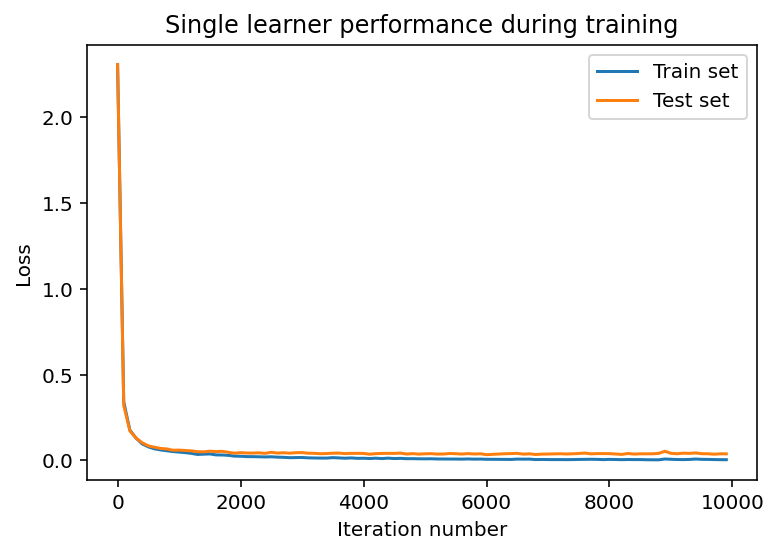

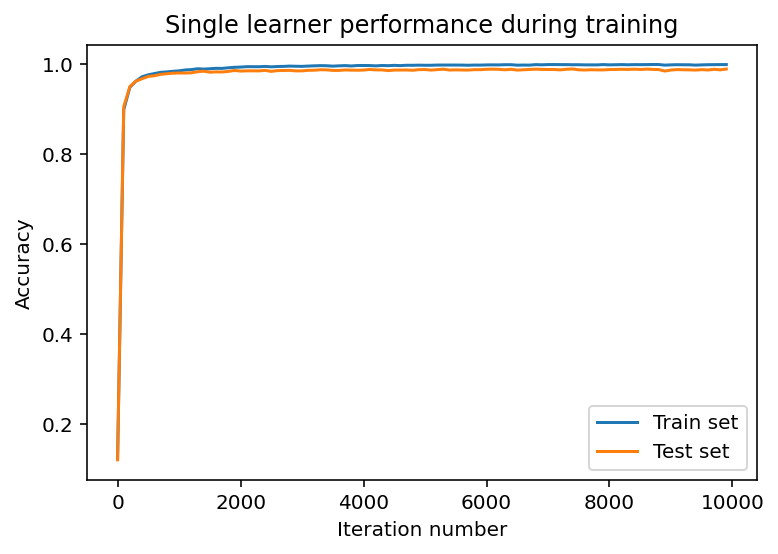

Substituting symbol L from STIXNonUnicode
Substituting symbol L from STIXNonUnicode


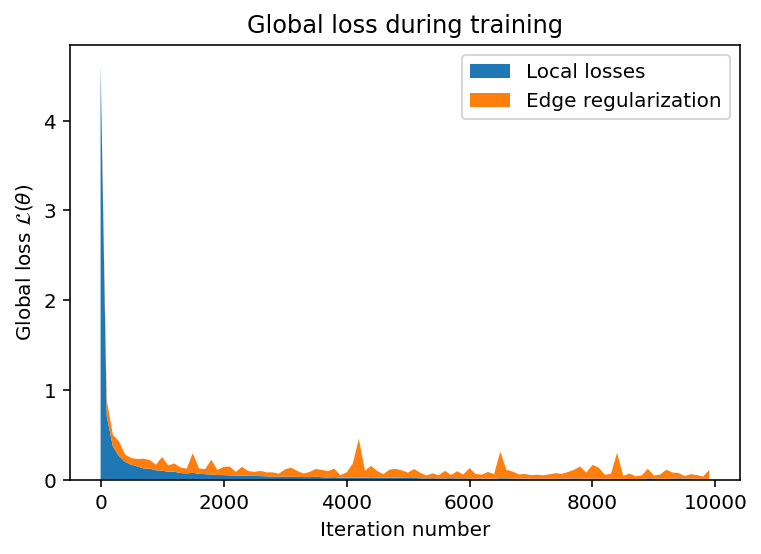

In [32]:
plt.figure()
plt.plot(range(0,100*len(train_losses),100),train_losses,label="Train set")
plt.plot(range(0,100*len(train_losses),100),test_losses,label="Test set")
plt.title("Single learner performance during training")
plt.xlabel("Iteration number")
plt.ylabel("Loss")
plt.legend()

plt.figure()
plt.plot(range(0,100*len(train_losses),100),train_accuracies,label="Train set")
plt.plot(range(0,100*len(train_losses),100),test_accuracies,label="Test set")
plt.title("Single learner performance during training")
plt.xlabel("Iteration number")
plt.ylabel("Accuracy")
plt.legend()

plt.figure()
plt.stackplot(range(0,100*len(train_losses),100), L_losses, L_regs, labels=["Local losses", "Edge regularization"])
plt.title("Global loss during training")
plt.ylabel(r"Global loss $\mathcal{L}(\theta)$")
plt.xlabel("Iteration number")
plt.legend()

# Run the experiment with varying lambda

In [33]:
lambdas = np.logspace(-2,3,30) # From 0.001 to 100
results = []
for lambd in tqdm(lambdas):
    subresults = run_experiment(2, 10000, lambd, True)
    train_loss = list(zip(*subresults))[0][-1]
    train_accuracy = list(zip(*subresults))[1][-1]
    test_loss = list(zip(*subresults))[2][-1]
    test_accuracy = list(zip(*subresults))[3][-1]
    results.append((train_loss,train_accuracy,test_loss,test_accuracy))


Test set: Average loss: 0.0007, Accuracy: 29994/30000 (100%)


Test set: Average loss: 0.0371, Accuracy: 9910/10000 (99%)





Test set: Average loss: 0.0006, Accuracy: 29997/30000 (100%)


Test set: Average loss: 0.0464, Accuracy: 9900/10000 (99%)





Test set: Average loss: 0.0013, Accuracy: 29988/30000 (100%)


Test set: Average loss: 0.0475, Accuracy: 9883/10000 (99%)





Test set: Average loss: 0.0006, Accuracy: 29995/30000 (100%)


Test set: Average loss: 0.0500, Accuracy: 9894/10000 (99%)





Test set: Average loss: 0.0006, Accuracy: 29997/30000 (100%)


Test set: Average loss: 0.0405, Accuracy: 9897/10000 (99%)





Test set: Average loss: 0.0005, Accuracy: 29996/30000 (100%)


Test set: Average loss: 0.0438, Accuracy: 9896/10000 (99%)





Test set: Average loss: 0.0011, Accuracy: 29991/30000 (100%)


Test set: Average loss: 0.0456, Accuracy: 9872/10000 (99%)





Test set: Average loss: 0.0009, Accuracy: 29991/30000 (100%)


Test set: Average loss: 0.0417, Accuracy: 9895/10000 (99%)





Test set: Average loss: 0.0006, Accuracy: 29995/30000 (100%)


Test set: Average loss: 0.0381, Accuracy: 9904/10000 (99%)





Test set: Average loss: 0.0009, Accuracy: 29994/30000 (100%)


Test set: Average loss: 0.0404, Accuracy: 9899/10000 (99%)





Test set: Average loss: 0.0013, Accuracy: 29987/30000 (100%)


Test set: Average loss: 0.0426, Accuracy: 9892/10000 (99%)





Test set: Average loss: 0.0028, Accuracy: 29980/30000 (100%)


Test set: Average loss: 0.0344, Accuracy: 9896/10000 (99%)





Test set: Average loss: 0.0033, Accuracy: 29976/30000 (100%)


Test set: Average loss: 0.0389, Accuracy: 9884/10000 (99%)





Test set: Average loss: 0.0058, Accuracy: 29944/30000 (100%)


Test set: Average loss: 0.0359, Accuracy: 9888/10000 (99%)





Test set: Average loss: 0.0082, Accuracy: 29930/30000 (100%)


Test set: Average loss: 0.0346, Accuracy: 9882/10000 (99%)





Test set: Average loss: 0.0175, Accuracy: 29844/30000 (99%)


Test set: Average loss: 0.0408, Accuracy: 9860/10000 (99%)





Test set: Average loss: 0.0185, Accuracy: 29821/30000 (99%)


Test set: Average loss: 0.0405, Accuracy: 9870/10000 (99%)





Test set: Average loss: 0.0325, Accuracy: 29710/30000 (99%)


Test set: Average loss: 0.0456, Accuracy: 9855/10000 (99%)





Test set: Average loss: 0.0808, Accuracy: 29316/30000 (98%)


Test set: Average loss: 0.0890, Accuracy: 9732/10000 (97%)





Test set: Average loss: 0.0406, Accuracy: 29629/30000 (99%)


Test set: Average loss: 0.0536, Accuracy: 9814/10000 (98%)





Test set: Average loss: 0.0627, Accuracy: 29430/30000 (98%)


Test set: Average loss: 0.0652, Accuracy: 9788/10000 (98%)





Test set: Average loss: 0.0688, Accuracy: 29389/30000 (98%)


Test set: Average loss: 0.0741, Accuracy: 9770/10000 (98%)





Test set: Average loss: 0.0955, Accuracy: 29153/30000 (97%)


Test set: Average loss: 0.0980, Accuracy: 9683/10000 (97%)





Test set: Average loss: 0.2172, Accuracy: 28285/30000 (94%)


Test set: Average loss: 0.2160, Accuracy: 9412/10000 (94%)





Test set: Average loss: 0.0993, Accuracy: 29098/30000 (97%)


Test set: Average loss: 0.0987, Accuracy: 9689/10000 (97%)





Test set: Average loss: 0.2770, Accuracy: 27582/30000 (92%)


Test set: Average loss: 0.2653, Accuracy: 9260/10000 (93%)





Test set: Average loss: 0.3634, Accuracy: 27033/30000 (90%)


Test set: Average loss: 0.3466, Accuracy: 9050/10000 (90%)





Test set: Average loss: 0.5387, Accuracy: 25549/30000 (85%)


Test set: Average loss: 0.5068, Accuracy: 8628/10000 (86%)





Test set: Average loss: 0.5525, Accuracy: 25458/30000 (85%)


Test set: Average loss: 0.5355, Accuracy: 8547/10000 (85%)





Test set: Average loss: 0.3033, Accuracy: 27451/30000 (92%)


Test set: Average loss: 0.2889, Accuracy: 9186/10000 (92%)





In [34]:
train_losses = list(zip(*results))[0]
train_accuracies = list(zip(*results))[1]
test_losses = list(zip(*results))[2]
test_accuracies = list(zip(*results))[3]

The first accuracy is 0.991
The best accuracy is 0.991 , achieved by lambda= 0.01


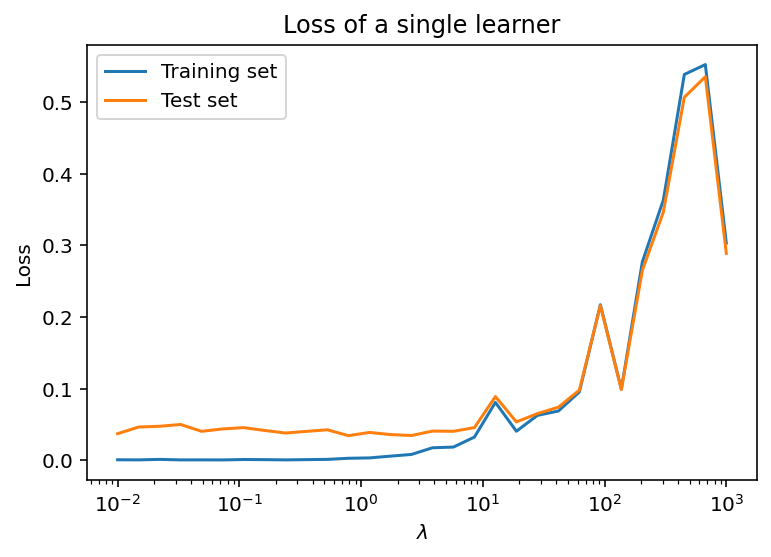

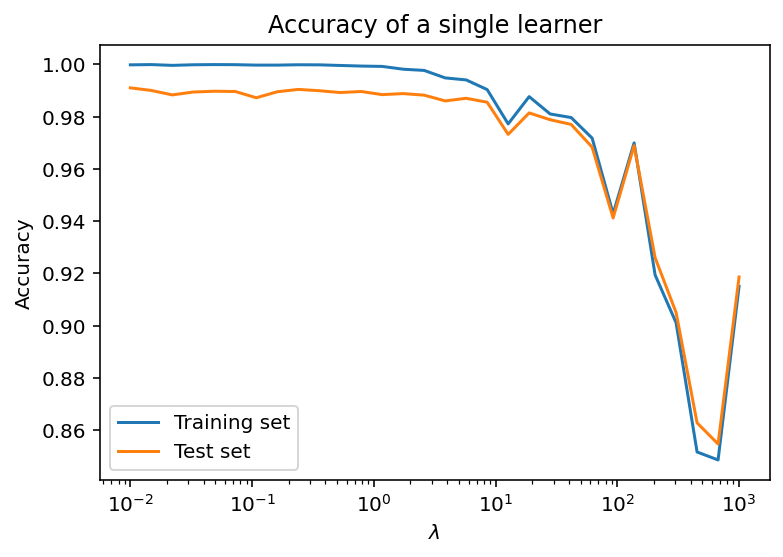

In [35]:
# 50 learners learning with ADAM and L2 norm for 5000 steps. The end state for a single learner.

plt.figure()
plt.plot(lambdas,train_losses, label="Training set")
plt.plot(lambdas,test_losses, label="Test set")
plt.legend()
plt.xscale('log')
plt.title("Loss of a single learner")
plt.ylabel("Loss")
plt.xlabel(r"$\lambda$")
plt.figure()
plt.plot(lambdas,train_accuracies, label="Training set")
plt.plot(lambdas,test_accuracies, label="Test set")
plt.legend()
plt.xscale('log')
plt.title("Accuracy of a single learner")
plt.ylabel("Accuracy")
plt.xlabel(r"$\lambda$");
print("The first accuracy is",test_accuracies[0])
print("The best accuracy is",np.max(test_accuracies),", achieved by lambda=",lambdas[np.argmax(test_accuracies)])

# Instead of full average, only share earlier layers

In [35]:
lambdas = np.logspace(-1,5,30) # From 0.001 to 100
results = []
for lambd in tqdm(lambdas):
    subresults = run_experiment(n_learners=2, n_iterations=10000, lambd=lambd, last_only=True, g=L2_early_squared)
    train_loss = list(zip(*subresults))[0][-1]
    train_accuracy = list(zip(*subresults))[1][-1]
    test_loss = list(zip(*subresults))[2][-1]
    test_accuracy = list(zip(*subresults))[3][-1]
    results.append((train_loss,train_accuracy,test_loss,test_accuracy))


Test set: Average loss: 0.0002, Accuracy: 29999/30000 (100%)


Test set: Average loss: 0.0547, Accuracy: 9902/10000 (99%)





Test set: Average loss: 0.0002, Accuracy: 29999/30000 (100%)


Test set: Average loss: 0.0409, Accuracy: 9904/10000 (99%)





Test set: Average loss: 0.0003, Accuracy: 29998/30000 (100%)


Test set: Average loss: 0.0437, Accuracy: 9921/10000 (99%)





Test set: Average loss: 0.0002, Accuracy: 29999/30000 (100%)


Test set: Average loss: 0.0414, Accuracy: 9916/10000 (99%)





Test set: Average loss: 0.0002, Accuracy: 30000/30000 (100%)


Test set: Average loss: 0.0517, Accuracy: 9899/10000 (99%)





Test set: Average loss: 0.0003, Accuracy: 29999/30000 (100%)


Test set: Average loss: 0.0395, Accuracy: 9908/10000 (99%)





Test set: Average loss: 0.0003, Accuracy: 29999/30000 (100%)


Test set: Average loss: 0.0423, Accuracy: 9911/10000 (99%)





Test set: Average loss: 0.0004, Accuracy: 29998/30000 (100%)


Test set: Average loss: 0.0456, Accuracy: 9911/10000 (99%)





Test set: Average loss: 0.0004, Accuracy: 29997/30000 (100%)


Test set: Average loss: 0.0539, Accuracy: 9893/10000 (99%)





Test set: Average loss: 0.0004, Accuracy: 29996/30000 (100%)


Test set: Average loss: 0.0460, Accuracy: 9897/10000 (99%)





Test set: Average loss: 0.0007, Accuracy: 29995/30000 (100%)


Test set: Average loss: 0.0572, Accuracy: 9893/10000 (99%)





Test set: Average loss: 0.0009, Accuracy: 29994/30000 (100%)


Test set: Average loss: 0.0501, Accuracy: 9893/10000 (99%)





Test set: Average loss: 0.0006, Accuracy: 29996/30000 (100%)


Test set: Average loss: 0.0460, Accuracy: 9897/10000 (99%)





Test set: Average loss: 0.0025, Accuracy: 29977/30000 (100%)


Test set: Average loss: 0.0436, Accuracy: 9889/10000 (99%)





Test set: Average loss: 0.0022, Accuracy: 29981/30000 (100%)


Test set: Average loss: 0.0446, Accuracy: 9885/10000 (99%)





Test set: Average loss: 0.0052, Accuracy: 29956/30000 (100%)


Test set: Average loss: 0.0452, Accuracy: 9885/10000 (99%)





Test set: Average loss: 0.0036, Accuracy: 29969/30000 (100%)


Test set: Average loss: 0.0480, Accuracy: 9884/10000 (99%)





Test set: Average loss: 0.0035, Accuracy: 29971/30000 (100%)


Test set: Average loss: 0.0452, Accuracy: 9879/10000 (99%)





Test set: Average loss: 0.0051, Accuracy: 29951/30000 (100%)


Test set: Average loss: 0.0405, Accuracy: 9880/10000 (99%)





Test set: Average loss: 0.0330, Accuracy: 29670/30000 (99%)


Test set: Average loss: 0.0687, Accuracy: 9785/10000 (98%)





Test set: Average loss: 0.0235, Accuracy: 29776/30000 (99%)


Test set: Average loss: 0.0605, Accuracy: 9822/10000 (98%)





Test set: Average loss: 0.0728, Accuracy: 29294/30000 (98%)


Test set: Average loss: 0.0980, Accuracy: 9706/10000 (97%)





Test set: Average loss: 0.0676, Accuracy: 29360/30000 (98%)


Test set: Average loss: 0.0922, Accuracy: 9728/10000 (97%)





Test set: Average loss: 0.0276, Accuracy: 29724/30000 (99%)


Test set: Average loss: 0.0642, Accuracy: 9817/10000 (98%)





Test set: Average loss: 0.0364, Accuracy: 29652/30000 (99%)


Test set: Average loss: 0.0764, Accuracy: 9766/10000 (98%)





Test set: Average loss: 0.0267, Accuracy: 29730/30000 (99%)


Test set: Average loss: 0.0672, Accuracy: 9797/10000 (98%)





Test set: Average loss: 0.0961, Accuracy: 29071/30000 (97%)


Test set: Average loss: 0.1288, Accuracy: 9623/10000 (96%)





Test set: Average loss: 0.1259, Accuracy: 28817/30000 (96%)


Test set: Average loss: 0.1562, Accuracy: 9527/10000 (95%)





Test set: Average loss: 0.0787, Accuracy: 29293/30000 (98%)


Test set: Average loss: 0.1024, Accuracy: 9693/10000 (97%)





Test set: Average loss: 0.0317, Accuracy: 29699/30000 (99%)


Test set: Average loss: 0.0663, Accuracy: 9787/10000 (98%)





In [17]:
train_losses = list(zip(*results))[0]
train_accuracies = list(zip(*results))[1]
test_losses = list(zip(*results))[2]
test_accuracies = list(zip(*results))[3]

The first accuracy is 0.9897
The best accuracy is 0.9905 , achieved by lambda= 0.2592943797404667


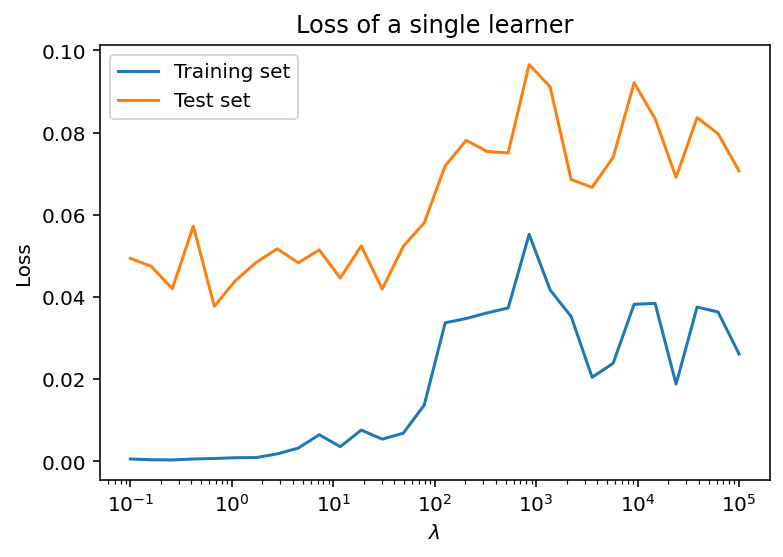

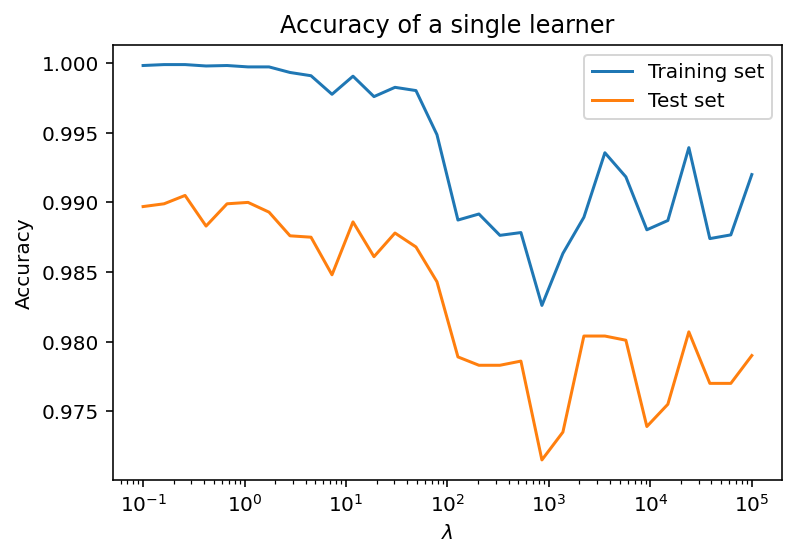

In [18]:
# 50 learners learning with ADAM and L2 norm for 5000 steps. The end state for a single learner.

plt.figure()
plt.plot(lambdas,train_losses, label="Training set")
plt.plot(lambdas,test_losses, label="Test set")
plt.legend()
plt.xscale('log')
plt.title("Loss of a single learner")
plt.ylabel("Loss")
plt.xlabel(r"$\lambda$")
plt.figure()
plt.plot(lambdas,train_accuracies, label="Training set")
plt.plot(lambdas,test_accuracies, label="Test set")
plt.legend()
plt.xscale('log')
plt.title("Accuracy of a single learner")
plt.ylabel("Accuracy")
plt.xlabel(r"$\lambda$");
print("The first accuracy is",test_accuracies[0])
print("The best accuracy is",np.max(test_accuracies),", achieved by lambda=",lambdas[np.argmax(test_accuracies)])

# 2 learners, with less data available and early sharing only

In [19]:
lambdas = np.logspace(-2,4,30) # From 0.001 to 100
results = []
for lambd in tqdm(lambdas):
    subresults = run_experiment(n_learners=2, n_iterations=10000, lambd=lambd, last_only=True, g=L2_early_squared, n_training_data=1000)
    train_loss = list(zip(*subresults))[0][-1]
    train_accuracy = list(zip(*subresults))[1][-1]
    test_loss = list(zip(*subresults))[2][-1]
    test_accuracy = list(zip(*subresults))[3][-1]
    results.append((train_loss,train_accuracy,test_loss,test_accuracy))


Test set: Average loss: 0.0000, Accuracy: 500/500 (100%)


Test set: Average loss: 0.5532, Accuracy: 9418/10000 (94%)





Test set: Average loss: 0.0000, Accuracy: 500/500 (100%)


Test set: Average loss: 0.4980, Accuracy: 9483/10000 (95%)





Test set: Average loss: 0.0000, Accuracy: 500/500 (100%)


Test set: Average loss: 0.6153, Accuracy: 9474/10000 (95%)





Test set: Average loss: 0.0000, Accuracy: 500/500 (100%)


Test set: Average loss: 0.7651, Accuracy: 9381/10000 (94%)





Test set: Average loss: 0.0000, Accuracy: 500/500 (100%)


Test set: Average loss: 0.6095, Accuracy: 9435/10000 (94%)





Test set: Average loss: 0.0000, Accuracy: 500/500 (100%)


Test set: Average loss: 0.5643, Accuracy: 9470/10000 (95%)





Test set: Average loss: 0.0000, Accuracy: 500/500 (100%)


Test set: Average loss: 0.6108, Accuracy: 9392/10000 (94%)





Test set: Average loss: 0.0000, Accuracy: 500/500 (100%)


Test set: Average loss: 0.7074, Accuracy: 9357/10000 (94%)





Test set: Average loss: 0.0000, Accuracy: 500/500 (100%)


Test set: Average loss: 0.6329, Accuracy: 9377/10000 (94%)





Test set: Average loss: 0.0000, Accuracy: 500/500 (100%)


Test set: Average loss: 0.7767, Accuracy: 9309/10000 (93%)





Test set: Average loss: 0.0000, Accuracy: 500/500 (100%)


Test set: Average loss: 0.6660, Accuracy: 9427/10000 (94%)





Test set: Average loss: 0.0000, Accuracy: 500/500 (100%)


Test set: Average loss: 1.0746, Accuracy: 9032/10000 (90%)





Test set: Average loss: 0.0000, Accuracy: 500/500 (100%)


Test set: Average loss: 0.7561, Accuracy: 9355/10000 (94%)





Test set: Average loss: 0.0000, Accuracy: 500/500 (100%)


Test set: Average loss: 0.8660, Accuracy: 9255/10000 (93%)





Test set: Average loss: 0.0000, Accuracy: 500/500 (100%)


Test set: Average loss: 1.0451, Accuracy: 9153/10000 (92%)





Test set: Average loss: 0.0000, Accuracy: 500/500 (100%)


Test set: Average loss: 1.0511, Accuracy: 9227/10000 (92%)





Test set: Average loss: 0.0000, Accuracy: 500/500 (100%)


Test set: Average loss: 0.7104, Accuracy: 9171/10000 (92%)





Test set: Average loss: 0.0000, Accuracy: 500/500 (100%)


Test set: Average loss: 0.9511, Accuracy: 9212/10000 (92%)





Test set: Average loss: 0.0000, Accuracy: 500/500 (100%)


Test set: Average loss: 1.1083, Accuracy: 9053/10000 (91%)





Test set: Average loss: 0.0000, Accuracy: 500/500 (100%)


Test set: Average loss: 0.7397, Accuracy: 9192/10000 (92%)





Test set: Average loss: 0.0000, Accuracy: 500/500 (100%)


Test set: Average loss: 1.4686, Accuracy: 8919/10000 (89%)





Test set: Average loss: 0.0000, Accuracy: 500/500 (100%)


Test set: Average loss: 1.2224, Accuracy: 8795/10000 (88%)





Test set: Average loss: 0.0000, Accuracy: 500/500 (100%)


Test set: Average loss: 0.7953, Accuracy: 9153/10000 (92%)





Test set: Average loss: 0.0000, Accuracy: 500/500 (100%)


Test set: Average loss: 1.2174, Accuracy: 9097/10000 (91%)





Test set: Average loss: 0.0000, Accuracy: 500/500 (100%)


Test set: Average loss: 1.3305, Accuracy: 9017/10000 (90%)





Test set: Average loss: 0.0000, Accuracy: 500/500 (100%)


Test set: Average loss: 1.2140, Accuracy: 9039/10000 (90%)





Test set: Average loss: 0.0000, Accuracy: 500/500 (100%)


Test set: Average loss: 1.2565, Accuracy: 8942/10000 (89%)





Test set: Average loss: 0.0000, Accuracy: 500/500 (100%)


Test set: Average loss: 1.1201, Accuracy: 9150/10000 (92%)





Test set: Average loss: 0.0000, Accuracy: 500/500 (100%)


Test set: Average loss: 1.0182, Accuracy: 9115/10000 (91%)





Test set: Average loss: 0.0000, Accuracy: 500/500 (100%)


Test set: Average loss: 1.1760, Accuracy: 9096/10000 (91%)





In [20]:
train_losses = list(zip(*results))[0]
train_accuracies = list(zip(*results))[1]
test_losses = list(zip(*results))[2]
test_accuracies = list(zip(*results))[3]

The first accuracy is 0.9418
The best accuracy is 0.9483 , achieved by lambda= 0.01610262027560939


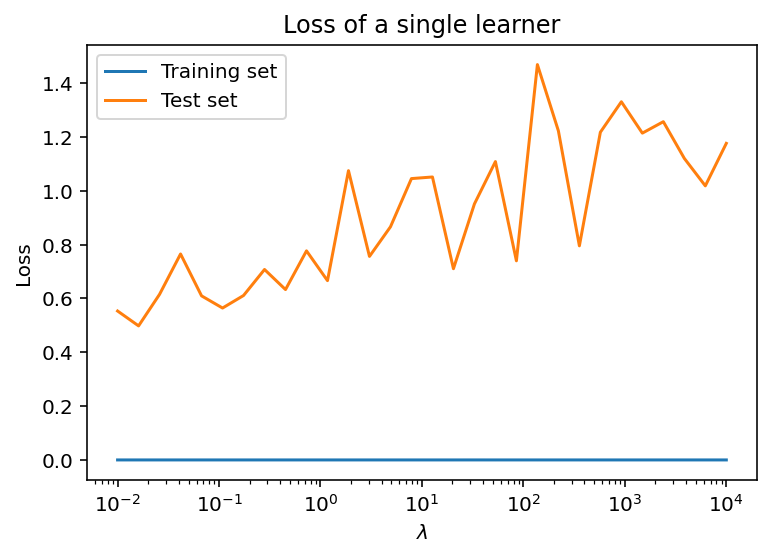

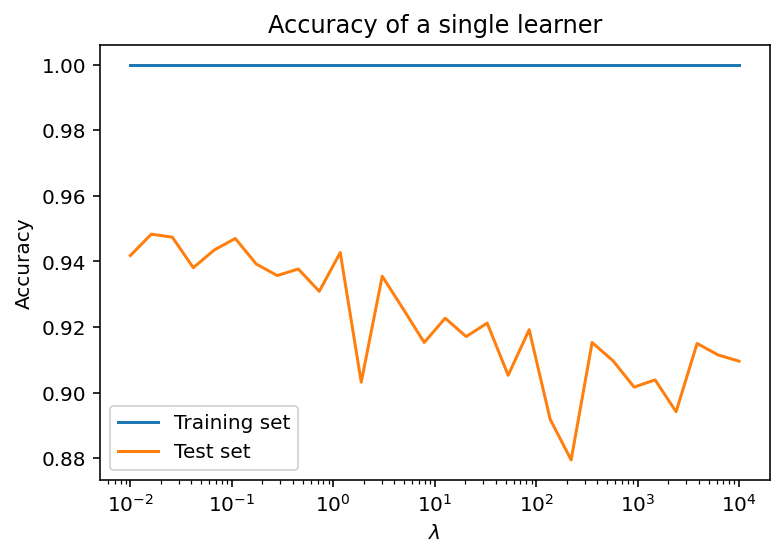

In [21]:
# 2 learners learning with ADAM and L2 norm for 10000 steps. The data in use is 1000 images for both.

plt.figure()
plt.plot(lambdas,train_losses, label="Training set")
plt.plot(lambdas,test_losses, label="Test set")
plt.legend()
plt.xscale('log')
plt.title("Loss of a single learner")
plt.ylabel("Loss")
plt.xlabel(r"$\lambda$")
plt.figure()
plt.plot(lambdas,train_accuracies, label="Training set")
plt.plot(lambdas,test_accuracies, label="Test set")
plt.legend()
plt.xscale('log')
plt.title("Accuracy of a single learner")
plt.ylabel("Accuracy")
plt.xlabel(r"$\lambda$");
print("The first accuracy is",test_accuracies[0])
print("The best accuracy is",np.max(test_accuracies),", achieved by lambda=",lambdas[np.argmax(test_accuracies)])

# Sharing of all but the last layer, less data

In [12]:
def pi_3(tensor):
    mask = torch.cat([torch.ones(1198592,device=DEVICE),torch.zeros(1290,device=DEVICE)])
    return tensor * mask

# Squared euclidian distance of all but the last layer
def L2_semiearly_squared(local,neighbor):
    return torch.norm(pi_3(local)-pi_3(neighbor)).pow(2)

In [14]:
lambdas = np.logspace(-2,4,30) # From 0.001 to 100
results = []
for lambd in tqdm(lambdas):
    subresults = run_experiment(n_learners=2, n_iterations=3000, lambd=lambd, last_only=True, g=L2_semiearly_squared, n_training_data=1000)
    train_loss = list(zip(*subresults))[0][-1]
    train_accuracy = list(zip(*subresults))[1][-1]
    test_loss = list(zip(*subresults))[2][-1]
    test_accuracy = list(zip(*subresults))[3][-1]
    results.append((train_loss,train_accuracy,test_loss,test_accuracy))


Test set: Average loss: 0.0000, Accuracy: 500/500 (100%)


Test set: Average loss: 0.4273, Accuracy: 9372/10000 (94%)





Test set: Average loss: 0.0000, Accuracy: 500/500 (100%)


Test set: Average loss: 0.5603, Accuracy: 9257/10000 (93%)





Test set: Average loss: 0.0000, Accuracy: 500/500 (100%)


Test set: Average loss: 0.4170, Accuracy: 9378/10000 (94%)





Test set: Average loss: 0.0000, Accuracy: 500/500 (100%)


Test set: Average loss: 0.4524, Accuracy: 9332/10000 (93%)





Test set: Average loss: 0.0000, Accuracy: 500/500 (100%)


Test set: Average loss: 0.4808, Accuracy: 9312/10000 (93%)





Test set: Average loss: 0.0000, Accuracy: 500/500 (100%)


Test set: Average loss: 0.4970, Accuracy: 9311/10000 (93%)





Test set: Average loss: 0.0000, Accuracy: 500/500 (100%)


Test set: Average loss: 0.5374, Accuracy: 9278/10000 (93%)





Test set: Average loss: 0.0000, Accuracy: 500/500 (100%)


Test set: Average loss: 0.4200, Accuracy: 9437/10000 (94%)





Test set: Average loss: 0.0000, Accuracy: 500/500 (100%)


Test set: Average loss: 0.4985, Accuracy: 9287/10000 (93%)





Test set: Average loss: 0.0000, Accuracy: 500/500 (100%)


Test set: Average loss: 0.4181, Accuracy: 9363/10000 (94%)





Test set: Average loss: 0.0000, Accuracy: 500/500 (100%)


Test set: Average loss: 0.4928, Accuracy: 9301/10000 (93%)





Test set: Average loss: 0.0001, Accuracy: 500/500 (100%)


Test set: Average loss: 0.4785, Accuracy: 9208/10000 (92%)





Test set: Average loss: 0.0000, Accuracy: 500/500 (100%)


Test set: Average loss: 0.4752, Accuracy: 9294/10000 (93%)





Test set: Average loss: 0.0000, Accuracy: 500/500 (100%)


Test set: Average loss: 0.4350, Accuracy: 9290/10000 (93%)





Test set: Average loss: 0.0000, Accuracy: 500/500 (100%)


Test set: Average loss: 0.3978, Accuracy: 9274/10000 (93%)





Test set: Average loss: 0.0023, Accuracy: 500/500 (100%)


Test set: Average loss: 0.4041, Accuracy: 9150/10000 (92%)





Test set: Average loss: 0.0017, Accuracy: 500/500 (100%)


Test set: Average loss: 0.3702, Accuracy: 9234/10000 (92%)





Test set: Average loss: 0.0028, Accuracy: 500/500 (100%)


Test set: Average loss: 0.3906, Accuracy: 9124/10000 (91%)





Test set: Average loss: 0.0042, Accuracy: 500/500 (100%)


Test set: Average loss: 0.3245, Accuracy: 9153/10000 (92%)





Test set: Average loss: 0.0266, Accuracy: 499/500 (100%)


Test set: Average loss: 0.3453, Accuracy: 9044/10000 (90%)





Test set: Average loss: 0.0620, Accuracy: 498/500 (100%)


Test set: Average loss: 0.4123, Accuracy: 8819/10000 (88%)





Test set: Average loss: 0.2413, Accuracy: 467/500 (93%)


Test set: Average loss: 0.4693, Accuracy: 8619/10000 (86%)





Test set: Average loss: 0.1475, Accuracy: 478/500 (96%)


Test set: Average loss: 0.3942, Accuracy: 8824/10000 (88%)





Test set: Average loss: 0.2473, Accuracy: 466/500 (93%)


Test set: Average loss: 0.4716, Accuracy: 8531/10000 (85%)





Test set: Average loss: 0.2259, Accuracy: 467/500 (93%)


Test set: Average loss: 0.4113, Accuracy: 8783/10000 (88%)





Test set: Average loss: 0.2710, Accuracy: 469/500 (94%)


Test set: Average loss: 0.5144, Accuracy: 8501/10000 (85%)





Test set: Average loss: 0.4183, Accuracy: 448/500 (90%)


Test set: Average loss: 0.5927, Accuracy: 8298/10000 (83%)





Test set: Average loss: 0.5950, Accuracy: 421/500 (84%)


Test set: Average loss: 0.7197, Accuracy: 7914/10000 (79%)





Test set: Average loss: 0.5161, Accuracy: 417/500 (83%)


Test set: Average loss: 0.6325, Accuracy: 8147/10000 (81%)





Test set: Average loss: 1.5053, Accuracy: 314/500 (63%)


Test set: Average loss: 1.5908, Accuracy: 5820/10000 (58%)





In [15]:
train_losses = list(zip(*results))[0]
train_accuracies = list(zip(*results))[1]
test_losses = list(zip(*results))[2]
test_accuracies = list(zip(*results))[3]

The first accuracy is 0.9372
The best accuracy is 0.9437 , achieved by lambda= 0.2807216203941177


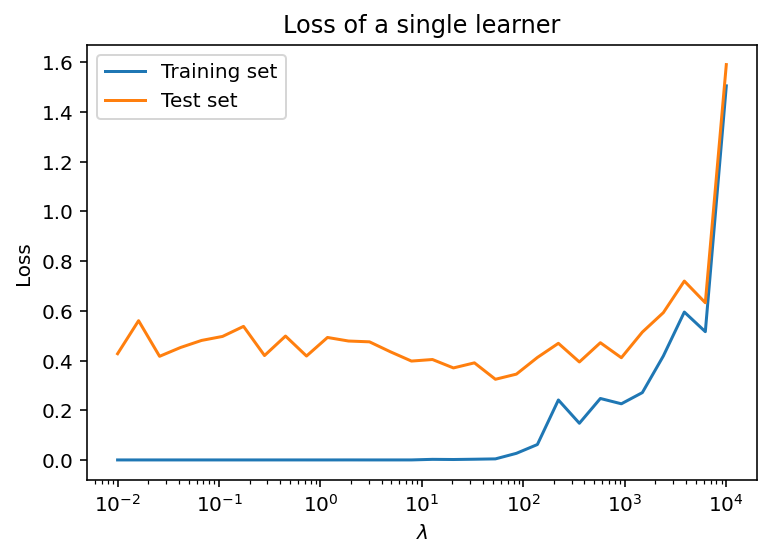

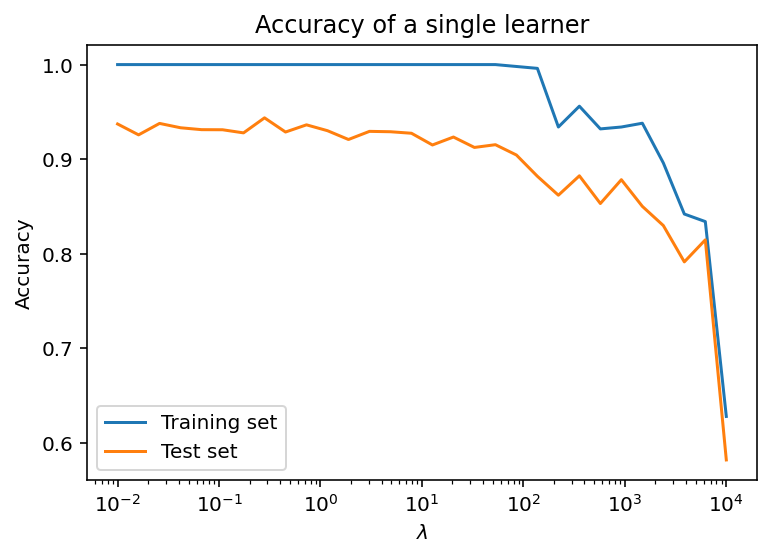

In [16]:
# 2 learners learning with ADAM and L2_squared_semiearly norm for 3000 steps. The data in use is 1000 images for both.

plt.figure()
plt.plot(lambdas,train_losses, label="Training set")
plt.plot(lambdas,test_losses, label="Test set")
plt.legend()
plt.xscale('log')
plt.title("Loss of a single learner")
plt.ylabel("Loss")
plt.xlabel(r"$\lambda$")
plt.figure()
plt.plot(lambdas,train_accuracies, label="Training set")
plt.plot(lambdas,test_accuracies, label="Test set")
plt.legend()
plt.xscale('log')
plt.title("Accuracy of a single learner")
plt.ylabel("Accuracy")
plt.xlabel(r"$\lambda$");
print("The first accuracy is",test_accuracies[0])
print("The best accuracy is",np.max(test_accuracies),", achieved by lambda=",lambdas[np.argmax(test_accuracies)])

# Run the same thing with 2 clusters

In [14]:
lambdas = np.logspace(-3,3,30) # From 0.001 to 100
results = []
for lambd in tqdm(lambdas):
    subresults = run_experiment(n_learners=60, n_iterations=10000, lambd=lambd, last_only=True, g=L2_early, p_in=0.5, p_out=0.1)
    train_loss = list(zip(*subresults))[0][-1]
    train_accuracy = list(zip(*subresults))[1][-1]
    test_loss = list(zip(*subresults))[2][-1]
    test_accuracy = list(zip(*subresults))[3][-1]
    results.append((train_loss,train_accuracy,test_loss,test_accuracy))


Test set: Average loss: 0.0007, Accuracy: 1000/1000 (100%)


Test set: Average loss: 0.2053, Accuracy: 9504/10000 (95%)





Test set: Average loss: 0.0008, Accuracy: 1000/1000 (100%)


Test set: Average loss: 0.2188, Accuracy: 9493/10000 (95%)





Test set: Average loss: 0.0009, Accuracy: 1000/1000 (100%)


Test set: Average loss: 0.2161, Accuracy: 9500/10000 (95%)





Test set: Average loss: 0.0004, Accuracy: 1000/1000 (100%)


Test set: Average loss: 0.2813, Accuracy: 9411/10000 (94%)





Test set: Average loss: 0.0004, Accuracy: 1000/1000 (100%)


Test set: Average loss: 0.2544, Accuracy: 9434/10000 (94%)





Test set: Average loss: 0.0007, Accuracy: 1000/1000 (100%)


Test set: Average loss: 0.2467, Accuracy: 9445/10000 (94%)





Test set: Average loss: 0.0017, Accuracy: 1000/1000 (100%)


Test set: Average loss: 0.2161, Accuracy: 9455/10000 (95%)





Test set: Average loss: 0.0008, Accuracy: 1000/1000 (100%)


Test set: Average loss: 0.2283, Accuracy: 9462/10000 (95%)





Test set: Average loss: 0.0015, Accuracy: 1000/1000 (100%)


Test set: Average loss: 0.2145, Accuracy: 9487/10000 (95%)





Test set: Average loss: 0.0015, Accuracy: 1000/1000 (100%)


Test set: Average loss: 0.2694, Accuracy: 9367/10000 (94%)





Test set: Average loss: 0.0024, Accuracy: 1000/1000 (100%)


Test set: Average loss: 0.2425, Accuracy: 9385/10000 (94%)





Test set: Average loss: 0.0042, Accuracy: 1000/1000 (100%)


Test set: Average loss: 0.2538, Accuracy: 9355/10000 (94%)





Test set: Average loss: 0.0103, Accuracy: 999/1000 (100%)


Test set: Average loss: 0.2345, Accuracy: 9366/10000 (94%)





Test set: Average loss: 0.0077, Accuracy: 1000/1000 (100%)


Test set: Average loss: 0.2135, Accuracy: 9422/10000 (94%)





Test set: Average loss: 0.0098, Accuracy: 1000/1000 (100%)


Test set: Average loss: 0.2628, Accuracy: 9286/10000 (93%)





Test set: Average loss: 0.0099, Accuracy: 1000/1000 (100%)


Test set: Average loss: 0.2510, Accuracy: 9318/10000 (93%)





Test set: Average loss: 0.0103, Accuracy: 1000/1000 (100%)


Test set: Average loss: 0.2457, Accuracy: 9294/10000 (93%)





Test set: Average loss: 0.0093, Accuracy: 1000/1000 (100%)


Test set: Average loss: 0.2483, Accuracy: 9294/10000 (93%)





Test set: Average loss: 0.0096, Accuracy: 1000/1000 (100%)


Test set: Average loss: 0.2378, Accuracy: 9301/10000 (93%)





Test set: Average loss: 0.0190, Accuracy: 998/1000 (100%)


Test set: Average loss: 0.2478, Accuracy: 9247/10000 (92%)





Test set: Average loss: 0.0107, Accuracy: 1000/1000 (100%)


Test set: Average loss: 0.2689, Accuracy: 9266/10000 (93%)





Test set: Average loss: 0.0288, Accuracy: 998/1000 (100%)


Test set: Average loss: 0.2457, Accuracy: 9283/10000 (93%)





Test set: Average loss: 0.0210, Accuracy: 1000/1000 (100%)


Test set: Average loss: 0.2315, Accuracy: 9331/10000 (93%)





Test set: Average loss: 0.0197, Accuracy: 999/1000 (100%)


Test set: Average loss: 0.2486, Accuracy: 9289/10000 (93%)





Test set: Average loss: 0.0178, Accuracy: 1000/1000 (100%)


Test set: Average loss: 0.2248, Accuracy: 9330/10000 (93%)





Test set: Average loss: 0.0349, Accuracy: 997/1000 (100%)


Test set: Average loss: 0.2150, Accuracy: 9351/10000 (94%)





Test set: Average loss: 0.0213, Accuracy: 1000/1000 (100%)


Test set: Average loss: 0.2251, Accuracy: 9315/10000 (93%)





Test set: Average loss: 0.0382, Accuracy: 996/1000 (100%)


Test set: Average loss: 0.2458, Accuracy: 9263/10000 (93%)





Test set: Average loss: 0.0334, Accuracy: 998/1000 (100%)


Test set: Average loss: 0.2443, Accuracy: 9286/10000 (93%)





Test set: Average loss: 0.0204, Accuracy: 999/1000 (100%)


Test set: Average loss: 0.2638, Accuracy: 9228/10000 (92%)





In [15]:
train_losses = list(zip(*results))[0]
train_accuracies = list(zip(*results))[1]
test_losses = list(zip(*results))[2]
test_accuracies = list(zip(*results))[3]

The first accuracy is 0.9504
The best accuracy is 0.9504 , achieved by lambda= 0.001


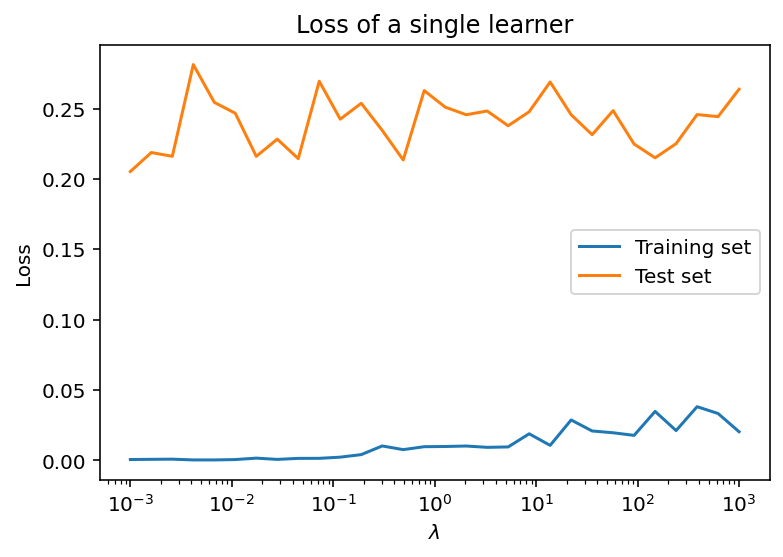

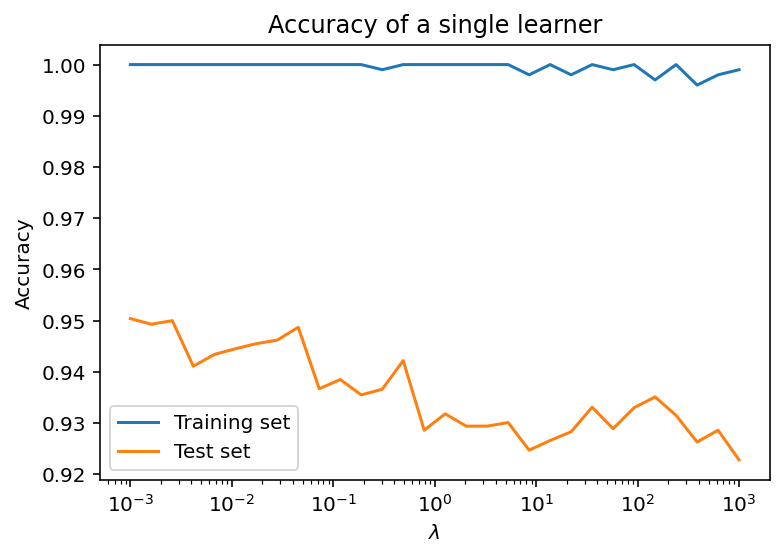

In [16]:
# 2 learners learning with ADAM and L2 norm for 10000 steps. The data in use is 1000 images for both.

plt.figure()
plt.plot(lambdas,train_losses, label="Training set")
plt.plot(lambdas,test_losses, label="Test set")
plt.legend()
plt.xscale('log')
plt.title("Loss of a single learner")
plt.ylabel("Loss")
plt.xlabel(r"$\lambda$")
plt.figure()
plt.plot(lambdas,train_accuracies, label="Training set")
plt.plot(lambdas,test_accuracies, label="Test set")
plt.legend()
plt.xscale('log')
plt.title("Accuracy of a single learner")
plt.ylabel("Accuracy")
plt.xlabel(r"$\lambda$");
print("The first accuracy is",test_accuracies[0])
print("The best accuracy is",np.max(test_accuracies),", achieved by lambda=",lambdas[np.argmax(test_accuracies)])